In [11]:
import pandas as pd
import numpy as np
from keras.models import Sequential,load_model
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import os
import joblib
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score


# Cargar el archivo y eliminar filas donde el clúster es NaN
file_path = 'data/data.csv'  # Cambia esta ruta al archivo que has subido
data = pd.read_csv(file_path)
data = data.dropna(subset=['Cluster_Label'])
# Convertir 'year' y 'month_no' a una sola columna de tipo fecha
data['date'] = pd.to_datetime(data['year'].astype(str) + '-' + data['month_no'].astype(str))

# Seleccionar las columnas necesarias para la serie temporal
columns_to_keep = ['date', 'species', 'Cluster_Label', 'landed_w_kg', 'value_mxn',
                   '0.49402499_m', '1.541375_m', '2.645669_m', '3.819495_m', '5.0782242_m',
                   '6.4406142_m', '7.9295602_m', '9.5729971_m', 'mean_temp']
data = data[columns_to_keep]

# Filtrar los datos para obtener una especie y un clúster específico
species_name = 'PARGO'  # Cambia esto a la especie que deseas usar
cluster_label = 1  # Cambia esto al clúster que deseas usar
filtered_data = data[(data['species'] == species_name) & (data['Cluster_Label'] == cluster_label)]

# Ordenar por fecha
filtered_data = filtered_data.sort_values('date')

# Función para preparar los datos
def prepare_data(group, look_back=6):
    features = ['landed_w_kg','Cluster_Label', '0.49402499_m', '1.541375_m', '2.645669_m', '3.819495_m', 
                '5.0782242_m', '6.4406142_m', '7.9295602_m', '9.5729971_m', 'mean_temp']
    scaler = MinMaxScaler(feature_range=(0, 1))
    group_scaled = scaler.fit_transform(group[features])
    
    X, y = [], []
    for i in range(len(group_scaled) - look_back):
        a = group_scaled[i:(i + look_back)]
        X.append(a)
        y.append(group_scaled[i + look_back, 0])  # La primera columna es 'landed_w_kg'
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))
    return X, y, scaler

# Función para crear y entrenar un modelo LSTM
def create_and_train_lstm_model(data, species_name, epochs=1000, batch_size=10):
    X, y, scaler = prepare_data(data)
    model = Sequential()
    model.add(LSTM(10, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(3, activation='linear'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
    model.fit(X, y, validation_split=0.2, epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[early_stopping])
    
    # Guardar el modelo y el scaler
    model_directory = 'modelos/model2'
    os.makedirs(model_directory, exist_ok=True)
    model_path = os.path.join(model_directory, f'{species_name}_model.h5')
    scaler_path = os.path.join(model_directory, f'{species_name}_scaler.pkl')
    model.save(model_path)
    joblib.dump(scaler, scaler_path)
    
    print(f'Modelo y scaler guardados para {species_name}')
    return model, scaler

# Entrenar el modelo
model, scaler = create_and_train_lstm_model(filtered_data, species_name)




Epoch 1/1000
1307/1307 [==============================] - 9s 5ms/step - loss: 8.0196e-04 - val_loss: 7.6640e-04
Epoch 2/1000
1307/1307 [==============================] - 6s 4ms/step - loss: 6.9254e-04 - val_loss: 7.3531e-04
Epoch 3/1000
1307/1307 [==============================] - 6s 4ms/step - loss: 6.8529e-04 - val_loss: 7.2452e-04
Epoch 4/1000
1307/1307 [==============================] - 6s 4ms/step - loss: 6.7369e-04 - val_loss: 6.9477e-04
Epoch 5/1000
1307/1307 [==============================] - 6s 4ms/step - loss: 6.5850e-04 - val_loss: 6.5066e-04
Epoch 6/1000
1307/1307 [==============================] - 6s 4ms/step - loss: 6.4379e-04 - val_loss: 6.7788e-04
Epoch 7/1000
1307/1307 [==============================] - 6s 4ms/step - loss: 6.3931e-04 - val_loss: 6.3050e-04
Epoch 8/1000
1307/1307 [==============================] - 6s 4ms/step - loss: 6.2860e-04 - val_loss: 6.3561e-04
Epoch 9/1000
1307/1307 [==============================] - 6s 4ms/step - loss: 6.3713e-04 - val_loss: 6.1

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


110/110 [==============================] - 1s 2ms/step
MSE: 118056.94830034515, R2: 0.20829213445162764


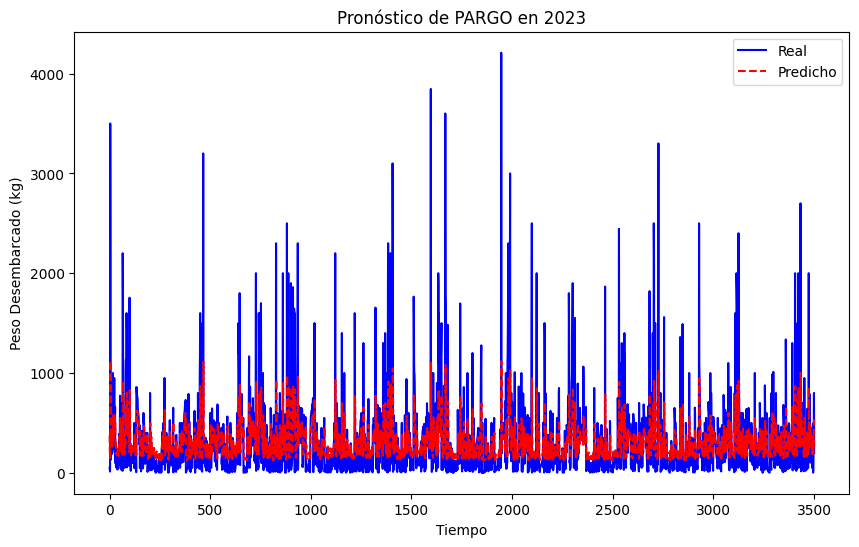

In [13]:
# Función para hacer predicciones
def predict_with_model(species_name, data, look_back=6):
    model_path = f'modelos/model2/{species_name}_model.h5'
    scaler_path = f'modelos/model2/{species_name}_scaler.pkl'
    
    model = load_model(model_path)
    scaler = joblib.load(scaler_path)
    
    features = ['landed_w_kg','Cluster_Label', '0.49402499_m', '1.541375_m', '2.645669_m', '3.819495_m', 
                '5.0782242_m', '6.4406142_m', '7.9295602_m', '9.5729971_m', 'mean_temp']
    group_scaled = scaler.transform(data[features])
    
    X = []
    for i in range(len(group_scaled) - look_back):
        a = group_scaled[i:(i + look_back)]
        X.append(a)
    X = np.array(X)
    X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))
    
    prediction_scaled = model.predict(X)
    prediction = scaler.inverse_transform(np.hstack((prediction_scaled, X[:, -1, 1:])))[:, 0]
    
    return prediction
look_back = 6 
# Filtrar los datos para el año 2023 y realizar predicciones
test_data_2023 = filtered_data[filtered_data['date'].dt.year == 2023]
if len(test_data_2023) >= look_back:
    predictions = predict_with_model(species_name, test_data_2023, look_back)
    real_values = test_data_2023['landed_w_kg'].values[look_back:]
    
    mse, r2 = mean_squared_error(real_values, predictions), r2_score(real_values, predictions)
    print(f'MSE: {mse}, R2: {r2}')
    
    # Crear figura
    plt.figure(figsize=(10, 6))
    plt.plot(real_values, color='blue', label='Real')
    plt.plot(predictions, color='red', linestyle='--', label='Predicho')
    plt.title(f'Pronóstico de {species_name} en 2023')
    plt.xlabel('Tiempo')
    plt.ylabel('Peso Desembarcado (kg)')
    plt.legend()
    plt.show()
else:
    print(f'No se tienen datos suficientes para {species_name} en 2023')